In [1]:
%cd ..


c:\Users\Sarthak\Documents\GitHub\port


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from src.prediction.kalman_filter import KalmanFilterPredictor
from src.prediction.lstm_model import LSTMPredictor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np


In [3]:

# Load historical data using yfinance
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2023-12-31'
# Load future data for testing (January 2024)
future_start_date = '2024-01-01'
future_end_date = '2025-03-30'


In [4]:


# Load historical data for training
df_train = yf.download(ticker, start=start_date, end=end_date) 
df_future = yf.download(ticker, start=future_start_date, end=future_end_date)

df_train.reset_index(inplace=True)
df_train = df_train.set_index('Date')
df_train = df_train.rename(columns={'Adj Close': 'adj_close'})

df_future.reset_index(inplace=True)
df_future = df_future.set_index('Date')
df_future = df_future.rename(columns={'Adj Close': 'adj_close'})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
df_future.tail()

,Open,High,Low,Close,adj_close,Volume
Date,,,,,,
2024-10-28,233.320007,234.729996,232.550003,233.399994,233.399994,36087100
2024-10-29,233.100006,234.330002,232.320007,233.669998,233.669998,35417200
2024-10-30,232.610001,233.470001,229.550003,230.100006,230.100006,47070900
2024-10-31,229.339996,229.830002,225.369995,225.910004,225.910004,64370100
2024-11-01,220.970001,225.350006,220.270004,222.910004,222.910004,65242200


In [6]:
# Initialize LSTM predictor
lstm_predictor = LSTMPredictor()
# Train the LSTM model for the given ticker
lstm_model, scaler = lstm_predictor.load_trained_model(ticker)

# Prepare LSTM data for testing
data, _ = lstm_predictor.preprocess_data(df_train)
time_step = 60
forecast_periods = len(df_future)

LSTM model loaded for AAPL


In [7]:
data = df_train['adj_close'].values.reshape(-1, 1)
data_scaled = scaler.transform(data)


In [8]:


# Use the last time_step values from training data to start predicting the future
X_future = data_scaled[-time_step:].reshape(1, time_step, 1)


In [9]:
forecast_periods

212

In [10]:

specified_day = 150
# Make predictions with LSTM for the future period (January 2024)
y_pred_lstm = []
for i in range(forecast_periods):
    pred = lstm_model.predict(X_future)
    y_pred_lstm.append(pred[0, 0])
    # Update X_future with the actual value if available, else use the prediction
    actual_value = scaler.transform(df_future['adj_close'].values[i].reshape(-1, 1)) if i < len(df_future) else pred
    if (i<specified_day):
        X_future = np.append(X_future[:, 1:, :], actual_value.reshape(1, 1, 1), axis=1)
    else:
        X_future = np.append(X_future[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Reverse the scaling of LSTM predictions
y_pred_lstm = scaler.inverse_transform(np.array(y_pred_lstm).reshape(-1, 1))

1/1 [==============================] - 0s 27ms/step


In [11]:
df_train = df_train[['adj_close']].reset_index().rename(columns={'Date': 'ds', 'adj_close': 'y'})
df_future = df_future[['adj_close']].reset_index().rename(columns={'Date': 'ds', 'adj_close': 'y'})

In [12]:
# Initialize Kalman Filter predictor
kalman_predictor = KalmanFilterPredictor()

# Train the Kalman Filter model for the given ticker
kalman_model = kalman_predictor.load_trained_model(ticker)

Kalman Filter model loaded for AAPL


In [13]:
# Generate a forecast for the future period (January 2024)
kalman_forecast = kalman_predictor.forecast(kalman_model, df_train, steps=forecast_periods)

In [14]:
# Align Kalman and LSTM Dates
actual_dates = df_future['ds']

In [15]:
days = np.arange(1, forecast_periods + 1)

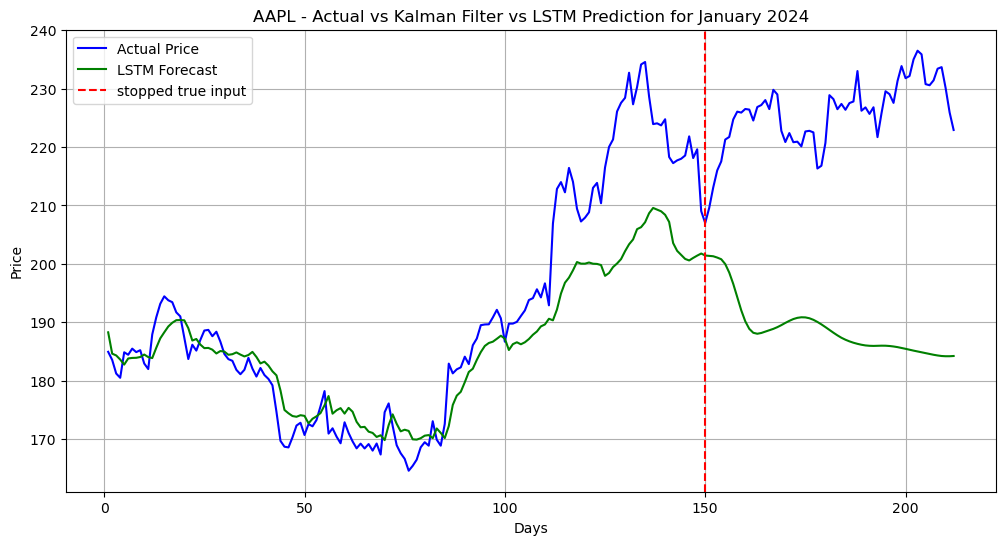

Mean Squared Error for Kalman Filter: 1286159.2802942991
Mean Squared Error for LSTM: 497.24575267165994


In [16]:
# Plot the Actual, Kalman Filter, and LSTM predictions
plt.figure(figsize=(12, 6))


# Plot the actual values
plt.plot(days, df_future['y'], label='Actual Price', color='blue')

# Plot the Kalman Filter forecast
#plt.plot(days, kalman_forecast['yhat'], label='Kalman Filter Forecast', color='orange')

# Plot the LSTM forecast
plt.plot(days, y_pred_lstm, label='LSTM Forecast', color='green')

plt.axvline(x=specified_day, color='red', linestyle='--', label=f'stopped true input')


plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f'{ticker} - Actual vs Kalman Filter vs LSTM Prediction for January 2024')
plt.legend()
plt.grid(True)
plt.show()
# Calculate and print Mean Squared Error for both methods
kalman_mse = mean_squared_error(df_future['y'], kalman_forecast['yhat'])
lstm_mse = mean_squared_error(df_future['y'], y_pred_lstm)

print(f"Mean Squared Error for Kalman Filter: {kalman_mse}")
print(f"Mean Squared Error for LSTM: {lstm_mse}")
